In [1]:
from functools import cache
import h5py
import numpy as np
import matplotlib.pyplot as plt
from numba_method import updateEz, updateHy
from boundary import abc, tfsfUpdate

SIZE = 350
maxTime = 350
LOSS = 0.02
LOSS_LAYER = 330
imp0 = 377.

def writeH5(filename, timestep, data):
    try:
        with h5py.File(filename, "a") as f:
            f[f"Ez/{str(timestep).zfill(5)}"] = data
    except:
        with h5py.File(filename, "w") as f:
            f[f"Ez/{str(timestep).zfill(5)}"] = data
    return

def readH5(filename):
    data = []
    with h5py.File(filename, "r") as f:
        for timestep in f["Ez"].keys():
            #print(timestep)
            data.append(f[f"Ez/{timestep}"][:])
    return np.asarray(data)

def InitCoef(imp0, sigma, cezh, ceze, chyh, chye):
    for mm in range(SIZE):
        if mm < 0:
            ceze[mm] = 1.0
            cezh[mm] = imp0
        elif mm < LOSS_LAYER:
            ceze[mm] = 1.0
            cezh[mm] = imp0 / sigma[mm] #9.0
        else:
            ceze[mm] = (1.0 - LOSS) / (1.0 + LOSS)
            cezh[mm] = imp0 / sigma[mm] / (1.0 + LOSS)
    
    for mm in range(SIZE - 1):
        if mm < 0:
            chyh[mm] = 1.0
            chye[mm] = 1.0 / imp0
        if mm < LOSS_LAYER:
            chyh[mm] = 1.0
            chye[mm] = 1.0 / imp0 / 1.0 
        else:
            chyh[mm] = (1.0 - LOSS) / (1.0 + LOSS)
            chye[mm] = 1.0 / imp0 / 1.0 / (1.0 + LOSS)
    return

def main():
    idx = np.arange(SIZE)
    
    ez = np.zeros(SIZE)
    hy = np.zeros(SIZE - 1)
    
    ceze = np.zeros(SIZE)
    cezh = np.zeros(SIZE)
    
    chye = np.zeros(SIZE - 1)
    chyh = np.zeros(SIZE - 1)
    
    for qTime in range(maxTime):
        sigma = np.linspace(1.0, 3.0, SIZE) + np.exp(qTime/100) #**2
        #sigma = np.power(sigma, 2.0)
        InitCoef(imp0, sigma, cezh, ceze, chyh, chye)          
        #rhs ABC removed               
        updateHy(ez, hy, chyh, chye, SIZE)        
        tfsfUpdate(hy, ez, chye, qTime)
        abc(ez)          
        updateEz(ez, hy, ceze, cezh, SIZE)
        writeH5("Ez.hdf5", qTime, ez)
        #writeH5("Sigma.hdf5", qTime, sigma)
    return

if __name__ == "__main__":
    main()


Text(0, 0.5, 'TimeStep')

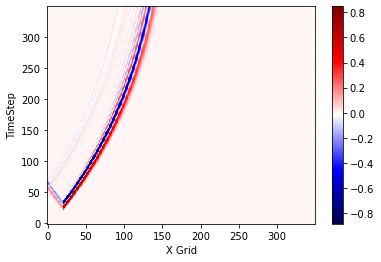

In [2]:
#SIZE = 300
#maxTime = 1000

x = np.arange(SIZE)
t = np.arange(maxTime)
#c = 1.0
#t_normal = t - x/c,

data = readH5("Ez.hdf5")
plt.pcolormesh(x, t, data, cmap = "seismic")
plt.colorbar()
plt.xlabel('X Grid')
plt.ylabel('TimeStep')
#plt.clim([-1, 1])
#plt.ylim([0, 100])

(0.0, 0.2)

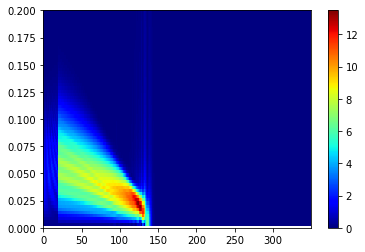

In [3]:
xf = np.fft.rfft(data[:], axis = 0)
dt = 1
freq = np.fft.rfftfreq(data[:].shape[0], d = dt)
df = freq[1] - freq[0]
freq += df

plt.pcolormesh(x, freq, np.abs(xf), cmap = "jet")
plt.colorbar()
plt.ylim([0, 0.2])
#plt.xlim([0, 6])